# Detection Methods

This code will consist of multiple methods to attempt to retrieve objects from images.


## Load Data

In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from match_image_data import convert_csv_2_dict, load_images_from_folder, get_drone_state



DATAFILE_DRONE = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_aggressive_flight/20190121-144708.csv"
IMAGES_FOLDER = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_aggressive_flight/20190121-144646/"
VIDEO_FILE = "/home/matthijs/robotics_q3/mav/cyberzoo.mp4"
VIDEO_FILE_SIM = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-03-11h21m26s-rtp_5000.sdp-.avi"
VIDEO_ALL_OBSTACLES = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-10-10h06m31s-rtp_5000.sdp-.avi"
VIDEO_ORANGE_AVOID = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-10-09h59m06s-rtp_5000.sdp-.avi"
SHOW_CV2_IMG = False
SHOW_VIDEO = True

drone_state_dict = convert_csv_2_dict(DATAFILE_DRONE)
images_cyberzoo_dict = load_images_from_folder(IMAGES_FOLDER)
images_cyberzoo = images_cyberzoo_dict["images"]
images_cyberzoo_stamp = images_cyberzoo_dict["timestamps"]

In [8]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [9]:
def show_img(img, gray_scale=False, img_name="img"):
    if SHOW_CV2_IMG:
        cv2.imshow(img_name, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        if gray_scale:
            cmap = "gray"
        else:
            cmap = None
        plt.imshow(img, cmap=cmap)



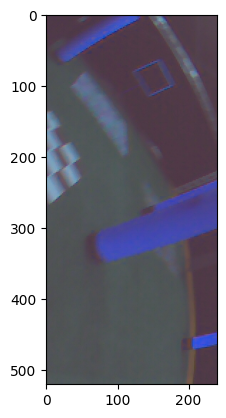

In [10]:
# Example image
example_img = images_cyberzoo[200]
img_name = "cyberzoo_example"
show_img(example_img)

## Edge Detection

### Handcrafted edge-detection

In [6]:
# convert to gray scale
def rgb_2_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


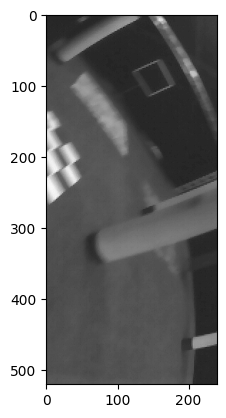

In [7]:
img = images_cyberzoo[200]
gray_img = rgb_2_gray(img)
show_img(gray_img, gray_scale=True)


In [8]:
def edge_detection(filter, image):
    gray_img = rgb_2_gray(image)
    edges_img = np.zeros_like(gray_img)
    N, M = gray_img.shape
    for row in range(3, N-2):
        for col in range(3,M-2):
            local_pixels = gray_img[row-1:row+2, col-1:col+2]
            transformed_pixels = filter * local_pixels
            score = (transformed_pixels.sum() + 4)/8
            edges_img[row,col] = score*3
    return edges_img

def canny_edge_detection(image, th1=100, th2=200):
    edges = cv2.Canny(image, th1, th2)
    return edges

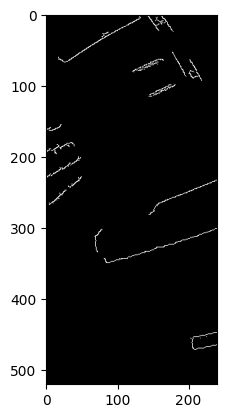

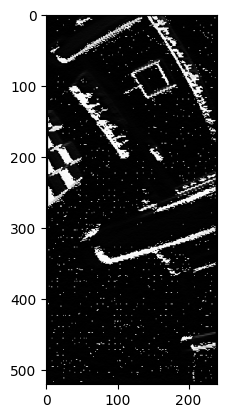

In [9]:
vertical_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
horizontal_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

canny_edges_img = canny_edge_detection(img)
ver_edges_img = edge_detection(vertical_filter,img)
hor_edges_img = edge_detection(horizontal_filter, img)
plt.figure(1)
plt.imshow(canny_edges_img, cmap="gray")
plt.figure(2)
show_img(ver_edges_img, gray_scale=True)

## Corner Detection

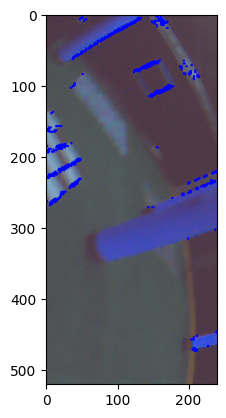

In [10]:
img = np.copy(images_cyberzoo[200])
gray = rgb_2_gray(img)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
show_img(img)
if cv2.waitKey(0) & 0xff == ord('q'):
    cv2.destroyAllWindows()

Leads to very useless data unfortunately

## SIFT/SURF/ORB

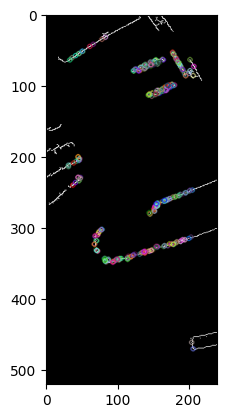

In [11]:
img = canny_edges_img # images_cyberzoo[200]
orb = cv2.ORB_create()
# surf = cv2.xfeatures2d.SURF_create()
keypoints, descriptors = orb.detectAndCompute(img, None)

img = cv2.drawKeypoints(img, keypoints, None)
plt.imshow(img)
if SHOW_CV2_IMG:
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
print(img.shape)

(520, 240, 3)


## Optical Flow

In [13]:



def smoothen_image(image, size):
    return cv2.blur(image, (size, size))

def optical_flow(cap, first_frame, smoothen=0):
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    # Creates an image filled with zero
    # intensities with the same dimensions 
    # as the frame
    mask = np.zeros_like(first_frame)
    
    # Sets image saturation to maximum
    mask[..., 1] = 255
    
    while(cap.isOpened()):
        
        # ret = a boolean return value from getting
        # the frame, frame = the current frame being
        # projected in the video
        ret, frame = cap.read()
        
        # Opens a new window and displays the input
        # frame
        cv2.imshow("input", frame)
        
        # Converts each frame to grayscale - we previously 
        # only converted the first frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, 
                                        None,
                                        0.5, 3, 45, 3, 5, 1.2, 0)
        
        # Computes the magnitude and angle of the 2D vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        # Sets image hue according to the optical flow 
        # direction
        mask[..., 0] = angle * 180 / np.pi / 2
        
        # Sets image value according to the optical flow
        # magnitude (normalized)
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        
        # Converts HSV to RGB (BGR) color representation
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

        gray_flow_img = rgb_2_gray(rgb)
        if smoothen > 0:
            gray_flow_img = smoothen_image(gray_flow_img, smoothen)
            #gray_flow_img = cv2.GaussianBlur(gray_flow_img, (9, 9),0)
        # Opens a new window and displays the output frame
        cv2.imshow("dense optical flow", gray_flow_img)
        cv2.imshow("dense optical flow", rgb)
        
        # Updates previous frame
        prev_gray = gray
        
        # Frames are read by intervals of 1 millisecond. The
        # programs breaks out of the while loop when the
        # user presses the 'q' key
        if cv2.waitKey(33) & 0xFF == ord('q'):
            break
    
    # The following frees up resources and
    # closes all windows
    cap.release()
    cv2.destroyAllWindows()

In [14]:
if SHOW_VIDEO:
    cap = cv2.VideoCapture(VIDEO_FILE_SIM)
    
    # ret = a boolean return value from
    # getting the frame, first_frame = the
    # first frame in the entire video sequence
    ret, first_frame = cap.read()
    optical_flow(cap, first_frame, smoothen=0)

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/matthijs/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [11]:
# This Optical flow implementation yields to way better results
import time
from collections import deque


def draw_flow(img, flow, step=16):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr


def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

def draw_flow_sides(flow_left, flow_right):
    img_flow_sides = np.zeros((200, 50))
    img_flow_sides[:100, :] = flow_left
    img_flow_sides[100:, :] = flow_right
    return img_flow_sides




if SHOW_VIDEO:

    cap = cv2.VideoCapture(VIDEO_ORANGE_AVOID)

    suc, prev = cap.read()

    prev = prev[160:360,95:145]
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    #prevgray = canny_edge_detection(prevgray)
    flow_left_queue = deque(maxlen=3)
    flow_right_queue = deque(maxlen=3)
    while True:

        suc, img = cap.read()
        if img is None:
            continue 
        img = img[160:360,95:145]
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #gray = canny_edge_detection(gray)
        # start time to calculate FPS
        start = time.time()


        flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_left = np.sum(np.linalg.norm(flow[:100,:], axis=2))
        flow_right = np.sum(np.linalg.norm(flow[100:,:], axis=2))
        flow_left_queue.append(flow_left)
        flow_right_queue.append(flow_right)
        sum_flow_left = np.sum(flow_left_queue)
        sum_flow_right = np.sum(flow_right_queue)

        flow_left_norm = sum_flow_left / max(sum_flow_left, sum_flow_right)
        flow_right_norm = sum_flow_right / max(sum_flow_left, sum_flow_right)

        print(flow_left_norm, flow_right_norm)
        prevgray = gray


        # End time
        end = time.time()
        # calculate the FPS for current frame detection
        fps = 1 / (end-start)

        print(f"{fps:.2f} FPS")

        cv2.imshow('flow', draw_flow(gray, flow))
        cv2.imshow('flow sides', draw_flow_sides(flow_left_norm, flow_right_norm))
        #cv2.imshow('flow HSV', draw_hsv(flow))


        key = cv2.waitKey(300)
        if key == ord('q'):
            break


    cap.release()
    cv2.destroyAllWindows()


1.0 0.8871653
657.62 FPS
0.9642385 1.0
621.29 FPS
1.0 0.9704773
340.28 FPS
0.99931324 1.0
538.91 FPS
1.0 0.93099725
514.32 FPS
1.0 0.99968046
557.46 FPS
1.0 0.7876371
541.13 FPS
1.0 0.746801
508.22 FPS
1.0 0.7528928
536.49 FPS
1.0 0.95773405
328.27 FPS
1.0 0.98603725
421.71 FPS
1.0 0.92783356
606.64 FPS
1.0 0.8881881
603.41 FPS
1.0 0.89251506
406.42 FPS
1.0 0.7957893
335.14 FPS
1.0 0.89315206
546.85 FPS
1.0 0.73379385
328.12 FPS
1.0 0.83037806
498.61 FPS
1.0 0.8336758
538.35 FPS
0.9645514 1.0
596.29 FPS
0.8860279 1.0
354.70 FPS
0.9214657 1.0
548.71 FPS
1.0 0.64922017
472.92 FPS
1.0 0.60444796
609.46 FPS
1.0 0.5589485
408.01 FPS
1.0 0.5798873
382.13 FPS
1.0 0.49101335
617.54 FPS
1.0 0.36406595
402.72 FPS
1.0 0.12760006
358.46 FPS
1.0 0.11800147
592.16 FPS
1.0 0.18753251
597.39 FPS
1.0 0.35387823
329.97 FPS
1.0 0.470296
586.45 FPS
1.0 0.5555101
550.72 FPS
1.0 0.61674184
634.54 FPS
1.0 0.64667445
630.25 FPS
1.0 0.5361573
578.29 FPS
1.0 0.303747
411.57 FPS
1.0 0.22367215
622.95 FPS
1.0 0.3

Proposed methods:
  1.  To extract objects from the noisy data: perform DBScan clustering twice. First on the color to get everything that has been appointed a similar color/similar depth with the optical flow and then a second round of clustering is performed on these Clusters. The problem with this approach is that you need to fit the second level clusters for each iteration. So this is not a feasible solution :(

## Background extraction

In [16]:
from __future__ import print_function
import cv2 as cv

# backSub = cv.createBackgroundSubtractorMOG2()
if 0:
    backSub = cv.createBackgroundSubtractorKNN()
    capture = cv.VideoCapture(cv.samples.findFileOrKeep(VIDEO_FILE_SIM))
    if not capture.isOpened():
        print('Unable to open: ' + VIDEO_FILE_SIM)
        exit(0)
    while True:
        ret, frame = capture.read()
        if frame is None:
            break
        
        fgMask = backSub.apply(frame)
        
        
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        
        
        cv.imshow('Frame', frame)
        cv.imshow('FG Mask', fgMask)
        
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break

## Color clustering

/home/matthijs/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


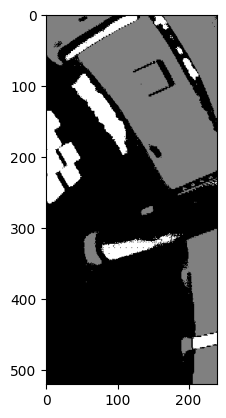

In [17]:
# Gray Scale
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=3)
img = rgb_2_gray(images_cyberzoo[200])
X = img.reshape(-1,1)
kmeans = cluster.fit(X)

lab = kmeans.labels_
img_clusters = 255/(lab.max() - lab.min()) * lab
img_clusters = img_clusters.reshape(img.shape)
plt.imshow(img_clusters, cmap="gray")


In [18]:
def perform_color_cluster(img, cluster):
    img_reshape = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    lab_color = cluster.predict(img_reshape)
    lab_color = lab_color.reshape(img.shape[0], img.shape[1])
    img_clustered = np.copy(img)
    for i in np.unique(lab_color):
        mean_color = np.mean(img[lab_color==i].T, axis=1)
        print(mean_color)
        img_clustered[lab_color==i] = mean_color
    return img_clustered

/home/matthijs/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[80.24674002 59.87576406 73.74113692]
[ 69.72930119  73.05590519 165.27674704]
[105.85828099 124.05255094 149.75869465]
[81.24244466 84.61949262 88.98843861]


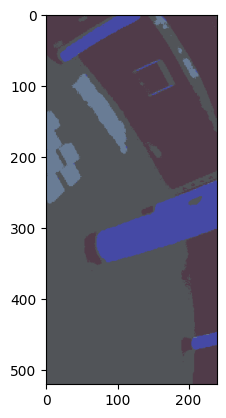

In [19]:
# Color Scale
from sklearn.cluster import DBSCAN

cluster_color = KMeans(n_clusters=4) #DBSCAN(eps=20, min_samples=100)
#cluster_color = DBSCAN(eps=5, min_samples=1000)

img = np.copy(images_cyberzoo[200])
img_reshape = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
dbscan = cluster_color.fit(img_reshape)
img_clustered = perform_color_cluster(img, cluster_color)
# lab_color = dbscan.labels_
# lab_color = lab_color.reshape(img.shape[0], img.shape[1])
# img_clustered = np.copy(img)
# for i in np.unique(lab_color):
#     mean_color = np.mean(img[lab_color==i].T, axis=1)
#     img_clustered[lab_color==i] = mean_color

show_img(img_clustered)

`cyberzoo[0]` gives quite a nice overview, so maybe we can use the clusterer trained on this set to predict on other sets.

[80.07065382 58.9848301  72.01566292]
[ 68.23046092  74.8494489  167.01127255]
[ 93.68425631 108.98115396 137.29602783]
[80.79366091 85.10951633 87.91300238]
[[[80 85 87]
  [80 85 87]
  [80 85 87]
  ...
  [80 58 72]
  [80 58 72]
  [80 58 72]]

 [[80 85 87]
  [80 85 87]
  [80 85 87]
  ...
  [80 58 72]
  [80 58 72]
  [80 58 72]]

 [[80 85 87]
  [80 85 87]
  [80 85 87]
  ...
  [80 58 72]
  [80 58 72]
  [80 58 72]]

 ...

 [[80 85 87]
  [80 85 87]
  [80 85 87]
  ...
  [80 58 72]
  [80 58 72]
  [80 58 72]]

 [[80 85 87]
  [80 85 87]
  [80 85 87]
  ...
  [80 58 72]
  [80 58 72]
  [80 58 72]]

 [[80 85 87]
  [80 85 87]
  [80 85 87]
  ...
  [80 58 72]
  [80 58 72]
  [80 58 72]]]


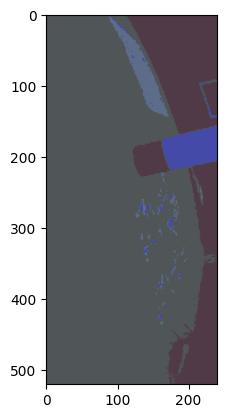

In [20]:
test_image = np.copy(images_cyberzoo[100])
clustered_test_image = perform_color_cluster(test_image, cluster_color)
print(clustered_test_image)
show_img(clustered_test_image)

This makes quite a good extinction between the ground, the pilars and the background so this could be quite useful

The annoying thing is that KMeans cant have variable boundaries and you cant predefine a boundary. So DBScan would be nice to use. However The data is a bit too dense to do this rn, so pooling could help allow the use of DBScan over KMeans. Maybe sth else than max pooling, since there are 3 channels with rgb images.


In [21]:
# import tensorflow as tf
# pooling_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))

def scale_down_img(img, factor=5):
    assert (img.shape[0]%factor==0 and img.shape[1]%factor==0), "not feasible scaling factor"
    scaled_img = np.zeros((img.shape[0]//factor, img.shape[1]//factor, img.shape[2]))
    for i in range(scaled_img.shape[0]):
        for j in range(scaled_img.shape[1]):
            scaled_img[i, j] = img[i*factor, j*factor]
    return scaled_img


[-1  0  1]


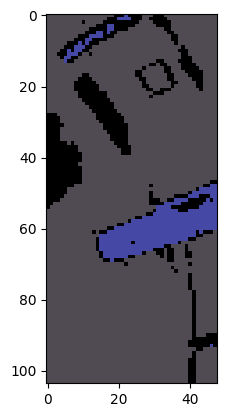

In [22]:
img = np.copy(images_cyberzoo[200])
scaled_img = scale_down_img(img)
show_img(img)

cluster_color = DBSCAN(eps=7, min_samples=50)

img_reshape = scaled_img.reshape(scaled_img.shape[0]*scaled_img.shape[1], scaled_img.shape[2])
lab_colors = cluster_color.fit_predict(img_reshape)

img_clustered = np.copy(scaled_img)
lab_colors = lab_colors.reshape(scaled_img.shape[0], scaled_img.shape[1])
for i in np.unique(lab_colors):
    if i==-1:
        print(np.unique(lab_colors))
        img_clustered[lab_colors==i] = np.array([0,0,0])
        continue
    mean_color = np.mean(scaled_img[lab_colors==i].T, axis=1)/255
    img_clustered[lab_colors==i] = mean_color

show_img(img_clustered)


0
[[0.2751543  0.28316129 0.65074007]
 [0.2751543  0.28316129 0.65074007]
 [0.2751543  0.28316129 0.65074007]
 ...
 [0.2751543  0.28316129 0.65074007]
 [0.2751543  0.28316129 0.65074007]
 [0.2751543  0.28316129 0.65074007]]


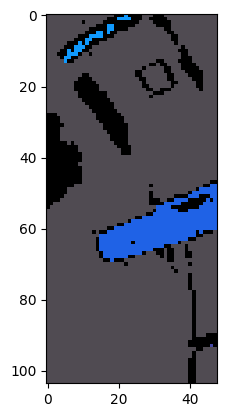

In [23]:
# For this we do need to identify which classes are the obstacles
OBS_CLASS = 1 # we still need a way to identify which classes represent obstacles
img_clustered_copy = np.copy(img_clustered)

obs_locations = np.argwhere(lab_colors==OBS_CLASS)
print(obs_locations[0,0])
print(img_clustered_copy[obs_locations[:,0], obs_locations[:,1]])
cluster_position = DBSCAN(eps=10, min_samples=5)
position_groups = cluster_position.fit_predict(obs_locations)
#print(obs_locations[position_groups==0])
for i in np.unique(position_groups):
    if i==-1:
        continue
    img_clustered_copy[obs_locations[position_groups==i][:,0], obs_locations[position_groups==i][:,1]] = np.random.random(3)
show_img(img_clustered_copy)



{'time': 48.481759, 'pos_x': -4.039062, 'pos_y': -0.777344, 'pos_z': -1.3174217460301207, 'vel_x': -1.079998, 'vel_y': 1.449997, 'vel_z': 1.7422181243725012, 'att_phi': 0.32499280217191034, 'att_theta': -0.2903055656182758, 'att_psi': 0.18600448908923262, 'rate_p': -1.8557218624115994, 'rate_q': -0.9673683667657078, 'rate_r': 0.3564796063927847, 'cmd_thrust': 5830.4989242905285, 'cmd_roll': -1121.238192808089, 'cmd_pitch': 652.8503227128413, 'cmd_yaw': 516.4989242905292}
104


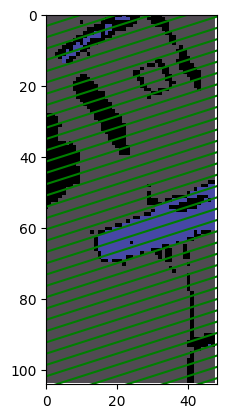

In [24]:
img = img_clustered
phi = get_drone_state(drone_state_dict, images_cyberzoo_stamp[200])['att_phi']
print(get_drone_state(drone_state_dict, images_cyberzoo_stamp[200]))
print(img.shape[0])
for i in np.linspace(0, img.shape[0] + 20, 40):
    x = np.linspace(0, img.shape[1], 100)
    y = -np.sin(phi) * x + SHOW_VIDEO
    show_img(img_clustered)
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)

    plt.plot(x, y, color="green")